# Simulating Spurious Association
This is a simple simulation of spurious associations based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot spurious associations.

Below `x_real` which is a truly causal predictor that influences both `y` and `x_spur`.

In [2]:
SAMP_SIZE = 10000 # size of sample

# all standardised -> mean=0, std=1
x_real = stats.norm.rvs(size=SAMP_SIZE)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

# creating a pandas dataframe
d = {'x_real': x_real,
    'x_spur': x_spur,
    'y': y}
df = pd.DataFrame(data=d)
df.head()

,x_real,x_spur,y
0,-0.610674,-1.339196,0.546679
1,-2.021242,-2.600094,-2.007615
2,0.447178,0.897685,-1.249449
3,1.673288,2.479040,1.378645
4,0.455043,-0.334751,0.599343


In [3]:
df.describe()

,x_real,x_spur,y
count,10000.000000,10000.000000,10000.000000
mean,-0.011744,-0.004626,-0.009088
std,0.994559,1.402946,1.394898
min,-3.967844,-5.468604,-5.300772
25%,-0.682874,-0.939208,-0.952037
50%,-0.007365,0.008015,-0.001360
75%,0.654256,0.937338,0.951952
max,3.670975,4.704592,4.982608


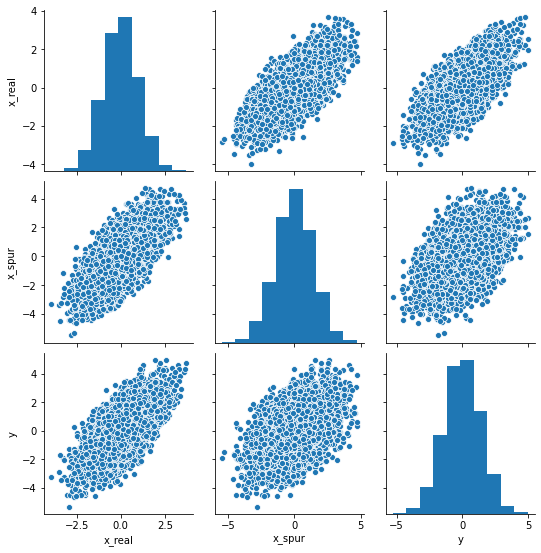

In [4]:
sns.pairplot(data=df)

We can notice by the pairplot above that `x_real` and `x_spur` seem be quite correlated to `y`.
<br>
<br>
The same can be seen on the correlation matrix bellow. However it's important to observe that the correlation between `x_spur` and `x_real` is quite high (as expected).

In [5]:
df.corr()

,x_real,x_spur,y
x_real,1.000000,0.698918,0.705203
x_spur,0.698918,1.000000,0.500694
y,0.705203,0.500694,1.000000


### Regressing with the real causal variable
Regressing for the real `x_real` data we can see bellow it totally correlated with `y`, as the coeficient is equal to `1` and has a tiny standard deviation of `0.1`.

In [6]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 1)
    mu = pm.Deterministic('mu', a + b*df['x_real'])
 
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
    
    real_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3043.77draws/s]


In [7]:
varnames = ['~mu']
az.summary(real_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.00,0.01,-0.02,0.02
b,0.99,0.01,0.97,1.01
sigma,0.99,0.01,0.97,1.00


### Regressing with the spurious variable
Regressing for the spurious `x_spur` data we can see bellow it has still a good level of correlation, of `0.5` and a tiny standard deviation of `0.1`, with `y`.

In [8]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    c = pm.Normal('c', 0, 1)
    mu = pm.Deterministic('mu', a + c*df['x_spur'])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
    
    spur_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2812.63draws/s]


In [9]:
varnames = ['~mu']
az.summary(spur_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.01,0.01,-0.03,0.02
c,0.50,0.01,0.48,0.51
sigma,1.21,0.01,1.19,1.22


### Multivariate regression
However when we include the variable `x_real` we have a different result as shown bellow:

In [10]:
with pm.Model() as full_model:
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 1)
    c = pm.Normal('c', 0, 1)
    mu = pm.Deterministic('mu', a + b*df['x_real'] + c*df['x_spur'])
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
    
    multi_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1967.58draws/s]
The acceptance probability does not match the target. It is 0.8904295113516922, but should be close to 0.8. Try to increase the number of tuning steps.


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

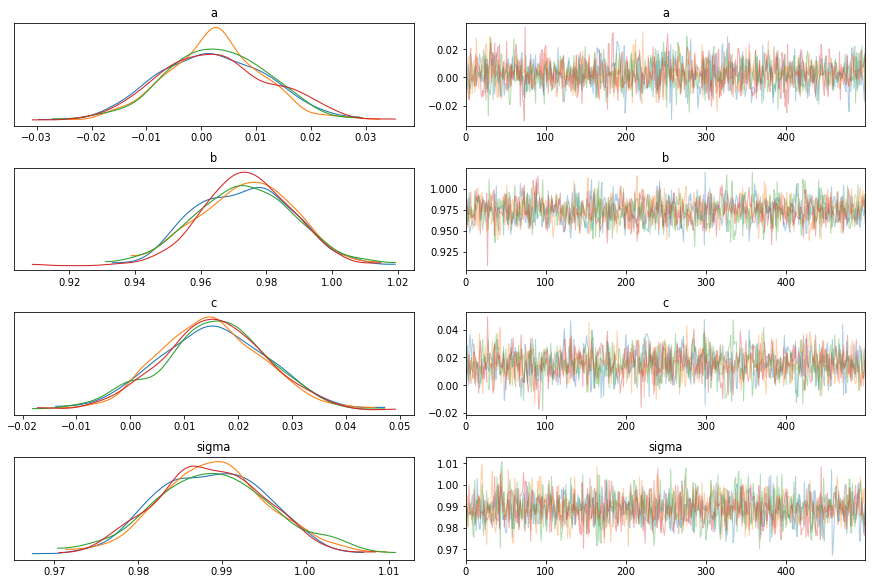

In [11]:
varnames = ['~mu']
az.plot_trace(multi_trace, var_names=varnames)

In [12]:
az.summary(multi_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.00,0.01,-0.01,0.02
b,0.97,0.01,0.95,1.00
c,0.02,0.01,-0.00,0.03
sigma,0.99,0.01,0.98,1.00


By using a mutiple regression we can spot that `x_spur`, is a spurious association to the variable `y` as its coeficient `c` is close to `0` with probability of both sides of `0` which means it does not explain the model.
<br>
<br>
It's interesting to notice that the value of `a` is also close to `0`, this is because the data is standardised (mean=0, std=1). 
<br>
<br>
Bellow we have the forest plot for the 3 models above representing the changing of both coeficients `b` and `c` for the 3 models. Notice there's a slight change on the correlation of `x_real` on the multivariate regression. On the other hand, the coeficient `c` goes to `0` on the multivariate regression.

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

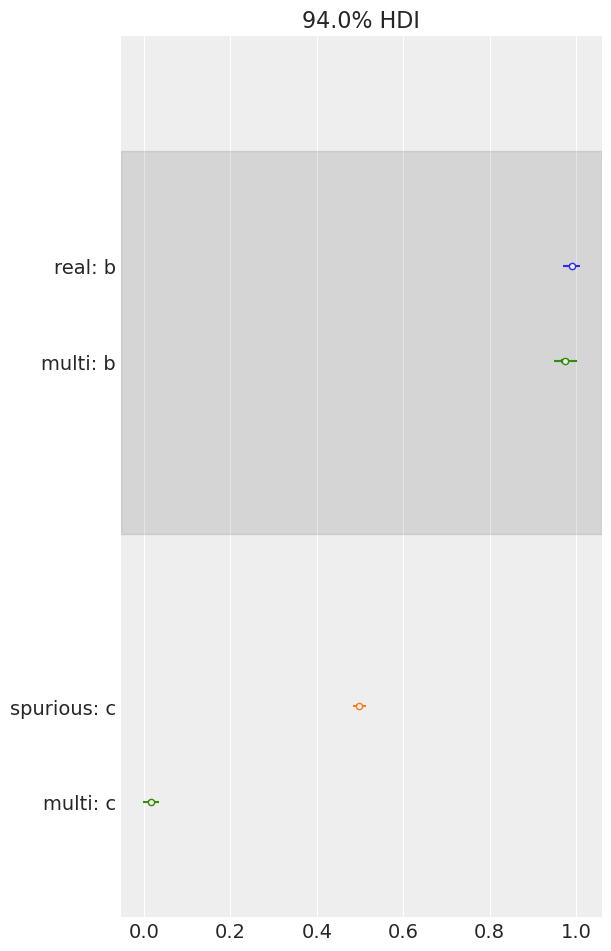

In [13]:
az.style.use("arviz-darkgrid")
az.plot_forest([real_trace, spur_trace, multi_trace], 
              model_names=["real", "spurious", "multi"],
              var_names=["b", "c"],
              combined=True)

### Conclusion*: 
<br>
Once we know `x_real` there's little or no additional predictive power in also knowing `x_spur`. However, if you don't have access to `x_real` then you'd definitely find value in knowing `x_spur`.

\* freely adapted from the book

### DAG representation
We can represent the causal relationship with the following DAG(Directed Acyclic Graph):

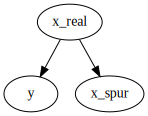

In [14]:
assoc = CausalGraphicalModel(
    nodes=["x_real", "x_spur", "y"], edges=[("x_real", "x_spur"), ("x_real", "y")]
)

assoc.draw()

In [15]:
%load_ext watermark
%watermark -iv -v -nuw

pandas  1.1.1
arviz   0.10.0
pymc3   3.8
seaborn 0.10.1
last updated: Sat Oct 31 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
